In [2]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from datetime import date
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import sys
from IPython.core.debugger import set_trace


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


###Load Data

In [25]:
m3_year = pd.read_excel('../data/M3C.xls',0)
m3_quar = pd.read_excel('../data/M3C.xls',1)
m3_mont = pd.read_excel('../data/M3C.xls',2)

len(m3_year)+len(m3_quar)+len(m3_mont)

print(type(m3_year.iloc[0,6:53]))

<class 'pandas.core.series.Series'>


###Transform to right format as a list of pandas dataframes each containing a timeseries (

In [48]:
year_dfs = []
for i in range (0,len(m3_year)):
    series = m3_year.iloc[i,6:53]
    init_year = m3_year.iloc[i,4]
    dates_list = [date(int(init_year+x),1,1) for x in range(0,len(series))] 
    df = pd.DataFrame(data= series.values, index = dates_list, columns = ["value"])
    df = df.convert_objects(convert_numeric=True)
    df = df[np.isfinite(df['value'])]
    year_dfs.append(df)
                  
quar_dfs = []
for i in range (0,len(m3_quar)):
    values = m3_quar.iloc[i,6:77]
    values = values.dropna()
    dates_list = [x for x in np.arange(m3_quar.iloc[i,4],m3_quar.iloc[i,4]+len(values),0.25)] 
    dates = pd.Series(dates_list)
    
    df = pd.concat([dates.rename('date'), values.rename('value')], axis=1)
    quar_dfs.append(df)
    
mont_dfs = []
for i in range (0,len(m3_mont)):
    values = m3_mont.iloc[i,6:149]
    values = values.dropna()
    dates_list = [x for x in np.arange(m3_mont.iloc[i,4],m3_mont.iloc[i,4]+len(values),0.083333333)] 
    dates = pd.Series(dates_list)
    dates.index += 1
    df = pd.concat([dates.rename('date'), values.rename('value')], axis=1)
    mont_dfs.append(df)

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


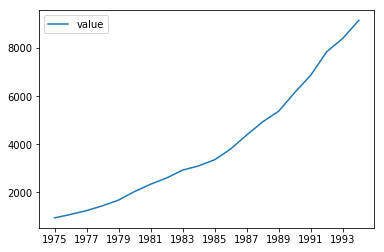

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 1975-01-01 to 1994-01-01
Data columns (total 1 columns):
value    20 non-null float64
dtypes: float64(1)
memory usage: 320.0+ bytes
              value
1975-01-01   940.66
1976-01-01  1084.86
1977-01-01  1244.98
1978-01-01  1445.02
1979-01-01  1683.17
1980-01-01  2038.15
1981-01-01  2342.52
1982-01-01  2602.45
1983-01-01  2927.87
1984-01-01  3103.96
1985-01-01  3360.27
1986-01-01  3807.63
1987-01-01  4387.88
1988-01-01  4936.99
1989-01-01  5379.75
1990-01-01  6158.68
1991-01-01  6876.58
1992-01-01  7851.91
1993-01-01  8407.84
1994-01-01  9156.01


In [49]:
year_dfs[0].plot()
plt.show()
year_dfs[0].info(0)
print(year_dfs[0])

In [50]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

print(pdq)

In [59]:
# Brute force exploration of the best set of pdq parameters

results_aic = [sys.maxsize] * len(year_dfs)
results = [None] * len(year_dfs)
i = 0
for ts in year_dfs:

    for param in pdq:
        try:
            model = ARIMA(ts, order=param)
            result = model.fit(disp=0)
            if result.aic < results_aic[i]:
                results_aic[i] = result.aic
                results[i] = result
              
        except Exception as e:
            print(e)
            continue
        
    i = i + 1
    print(i)

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1
2
3


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: Runti

SVD did not converge
4


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/

5
6


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7
8
9
10
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
11
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
12


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
13
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
14
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
15


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))


SVD did not converge
16
17
18
19
20
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
21
22
23
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
24
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
25
26
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)


27
28
29
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
30
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not converge
31
32
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
33
34
35
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


48
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
49
SVD did not converge
50
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
51
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
52
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
53
54
55
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


65
66


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


67
68
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
69
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
70
71
72
73
74
75
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
76
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
77
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
78
79
80
81


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


92
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
93
94
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
95
96
97
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
98
99
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
100
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
101
SVD did not converge
102
SVD did not converge
103
104
105
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model or

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


108
109
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
110
111
112
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
113
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
114
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
115
116
SVD did not converge
SVD did not converge
117
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
118
119
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model o

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


134
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
135
136
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
137
138


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


139
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
140
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
141
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
142
143
144
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
145
146
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not co

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


156
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
157
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
158
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
159
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
160
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
161


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


162
163
164
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
165
166
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
167
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
168
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
169
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
170
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
171
The c

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


172
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
173
174
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
175
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


176
177
178
SVD did not converge
179
180
181
182
183
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
184
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
185
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
186
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
187
SVD did not converge
188
189
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
190
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a differ

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


220
221
222
223
224
225
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
226


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


227
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
228
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
229
230
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
231
232
233
234
235
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
236
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
237
238
239
240
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own sta

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


291
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
292
293
294
295
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
296
297
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
298
299
300
301
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


302
303
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
304
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
305
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
306
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
307
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
308
The computed initi

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
317
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
318
319
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
320
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
321
The computed initial AR co

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


325
326
327
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
328
329
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
330
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not converge
331
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_para

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


333
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
334
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


335
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
336
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
337
338
339
340
341
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
342
343
344
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
345
346
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


362
363
364
365
366
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
367
368
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
369
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
370
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
371
372
373
374
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
375
376


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
377
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
378
379
380
381
382
383
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
384
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
385
SVD did not converge
386
387
388
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
389
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
p

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
398
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
399
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
400
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
401
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
402
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
403
The computed initial

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


412
413
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
414
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
415
416
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
417
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
418
419
420
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
421
The co

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
439
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
440
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
SVD did not converge
441


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


442
443
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
444
445
446
447
448
SVD did not converge
449
450
451
452
453
454
455
456
457
458
459
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
460
461
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
462
463
464
465
466
SVD did not converge
467
468
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
469
470
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
471
SVD did not converge
472
The computed initi

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


485
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
486
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
487
488
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
489
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
490
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial A

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


498
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
499


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


500


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


501
502
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
503
504
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
505
506
507
508
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
509
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
510
511
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
51

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
524
525
SVD did not converge
526
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
527
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
528
529
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
530
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
531
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own star

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


543
544
545
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
546
547
548
549
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
550
551
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
552
553
5

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


568
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
569


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


570
571
572
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
573


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


574
575
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
576
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


577


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


578
579
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
580
581


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


582
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
583
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


584
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
585
586
587
588
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
589
590
591
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
592


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
593
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
594
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
595
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
596
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
597
598
The computed initial A

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


602
SVD did not converge
603
604
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
605
606
607
608
609


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


610
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
611
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
612


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


613
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
614
615
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
616
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


617
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
618
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
619
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
620
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
621
The computed initial AR co

/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
632
633


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


634
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
635
636
637
638
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
639
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
640
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
641
642
643
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
644
645


In [60]:
len(results)

645

In [61]:
print(results[0].summary().tables[1])

                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           435.8135    131.133      3.323      0.004     178.798     692.829
ar.L1.D.value     0.7568      0.154      4.926      0.000       0.456       1.058


/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/cartest/anaconda3/envs/py3Env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
